<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/test_large_batch_optimezer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch

## Imports

In [ ]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torchvision
import torchvision.transforms as transforms
import random
import math
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR, LambdaLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Costants

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE_BASE = 64
#OPTIMIZER = 'LARS'  # Choose from: 'SGDM', 'LARS', 'AdamW', 'LAMB'
SAVE_PATH= f"/content/drive/My Drive/Colab Notebooks/Traning_summary/"
CHECKPOINT_NAME = f"checkpoint_last_large_batches.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




## Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [ ]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [ ]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")

    return train_dataset, train_loader, val_loader, test_loader

In [ ]:
class CheckpointSaver:

  def __init__(self, batch_size, hyperparams, epochs, optimizer, path=SAVE_PATH, checkpoint_name=CHECKPOINT_NAME):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = path
    self.hyperparams = hyperparams
    self.epochs = epochs
    self.checkpoint_name = checkpoint_name
    self.optimizer_name = optimizer
    self.create_files()


  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'train_acc': os.path.join(self.path, f'{self.optimizer_name}_{self.batch_size}_train_accuracy_{self.timestamp}.txt'),
        'val_acc': os.path.join(self.path, f'{self.optimizer_name}_{self.batch_size}_val_accuracy_{self.timestamp}.txt'),
        'train_loss': os.path.join(self.path, f'{self.optimizer_name}_{self.batch_size}_train_loss_{self.timestamp}.txt'),
        'val_loss': os.path.join(self.path, f'{self.optimizer_name}_{self.batch_size}_val_loss_{self.timestamp}.txt')
    }

    with open(os.path.join(self.path, f'{self.optimizer_name}_{self.batch_size}_experiment_config_{self.timestamp}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: {self.optimizer_name}\n")
        f.write(f"Batch Size: {self.batch_size}\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")


  def save_checkpoint(self, epoch, train_acc, val_acc, train_loss, val_loss):
      try:
          with open(self.metrics_files['train_acc'], 'a') as f:
              f.write(f"{epoch+1},{train_acc * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch+1},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['train_loss'], 'a') as f:
              f.write(f"{epoch+1},{train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch+1},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_model_checkpoint(self, model, optimizer, epoch):
    checkpoint_path = os.path.join(self.path, self.checkpoint_name)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
    except Exception as e:
        print(f"Error saving model checkpoint: {e}")

  def load_model_checkpoint(self, model, optimizer):
    try:
        checkpoint = torch.load(self.path + self.checkpoint_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded successfully. Resuming from epoch {start_epoch}")
        return start_epoch
    except Exception as e:
        print(f"Error loading model checkpoint: {e}")
        return 0

  def delete_checkpoint(self):
      final_path = self.path
      if os.path.exists(final_path):
            for file_name in os.listdir(final_path):
                file_path = os.path.join(final_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print(f"All existing checkpoints in {final_path} have been deleted.")
      else:
            print(f"No checkpoint folder found at {final_path}.")


## Defining different optimizers

In [ ]:
class LARS(Optimizer):
    # Initialize LARS optimizer with default parameters
    def __init__(self, params, lr=1e-3, beta1=0.9, batch_size=32, weight_decay=1e-4, epsilon=1e-8):
        defaults = dict(lr=lr, beta1=beta1, batch_size=batch_size,
                        weight_decay=weight_decay, epsilon=epsilon)
        super(LARS, self).__init__(params, defaults)

        # Initialize momentum buffers for each parameter group
        self.m0 = {param: torch.zeros_like(param.data) for group in self.param_groups
                   for param in group['params']}

    # Function to scale the learning rate dynamically (identity in this case)
    def phi(self, norm):
        return torch.ones_like(norm)

    # Select a random batch of samples from the dataset
    def get_batch_samples(self, dataset, batch_size):
        indices = torch.randperm(len(dataset))[:batch_size]
        return [dataset[i] for i in indices]

    @torch.no_grad()
    # Perform a single optimization step
    def step(self, closure=None, dataset=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1 = group['beta1']
            lr = group['lr']
            weight_decay = group['weight_decay']
            epsilon = group['epsilon']

            # If a dataset is provided, sample a batch for use in calculations
            if dataset is not None:
                batch = self.get_batch_samples(dataset, group['batch_size'])

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad
                state = self.state[param]

                # Compute the regularized gradient (gradient + weight decay term)
                gt = grad + weight_decay * param.data

                # Update the momentum term
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)
                mt = state['momentum']
                mt.mul_(beta1).add_((1 - beta1) * (gt + weight_decay * param.data))

                # Compute the parameter and momentum norms for scaling
                param_norm = param.data.norm(2).clamp(min=epsilon)
                mt_norm = mt.norm(2).clamp(min=epsilon)

                # Compute the scaled update
                update = lr * (self.phi(param_norm) / mt_norm) * mt

                # Apply the update to the parameters
                param.data.sub_(update)

        return loss


class LAMB(Optimizer):
    # Initialize LAMB optimizer with default parameters
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    # Perform a single optimization step
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                # Initialize state variables if they do not exist
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Update biased first moment estimate
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Update biased second moment estimate
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Apply bias correction to the first and second moment estimates
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                exp_avg_hat = exp_avg / bias_correction1
                exp_avg_sq_hat = exp_avg_sq / bias_correction2

                # Compute the scaled gradient update
                denom = exp_avg_sq_hat.sqrt().add_(group['eps'])
                update = exp_avg_hat / denom

                # Add weight decay term to the update
                if group['weight_decay'] > 0:
                    update.add_(p.data, alpha=group['weight_decay'])

                # Compute trust ratio for scaling the update
                w_norm = p.data.norm(p=2)
                g_norm = update.norm(p=2)
                trust_ratio = torch.where(
                    w_norm > 0,
                    w_norm / (g_norm + group['eps']),
                    torch.ones_like(w_norm)
                )

                # Apply the scaled update to the parameters
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss


## Training function

In [ ]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, hyperparams, num_epochs, device, type_of_optimizer, batch_size, train_dataset):
    # Initialize the model and move it to the specified device (CPU/GPU)
    model = LeNet5().to(device)

    # Configure optimizer based on the selected type and validate required hyperparameters
    if type_of_optimizer == "SGDM":
        if hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")
        optimizer = optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            momentum=hyperparams['momentum'],
            weight_decay=hyperparams['weight_decay']
        )

    elif type_of_optimizer == "AdamW":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")
        optimizer = optim.AdamW(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )

    elif type_of_optimizer == "LAMB":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LAMB")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LAMB")
        optimizer = LAMB(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )

    elif type_of_optimizer == "LARS":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LARS")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LARS")
        optimizer = LARS(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )
    else:
        raise ValueError("Invalid optimizer type")

    print(f"Train running with {type_of_optimizer} optimizer")

    # Create a CheckpointSaver to handle saving model and optimizer states
    cs = CheckpointSaver(
        batch_size=batch_size,
        hyperparams=hyperparams,
        epochs=num_epochs,
        optimizer=type_of_optimizer
    )

    # Check for existing checkpoint to resume training from the last saved epoch
    start_epoch = 0
    if os.path.exists(SAVE_PATH + CHECKPOINT_NAME):
        start_epoch = cs.load_model_checkpoint(model, optimizer)
        print(f"Recover from {start_epoch} epoch to train")
    else:
        print("Start training from the beginning")

    # Define learning rate schedulers for warmup and cosine annealing
    iterations_per_epoch = len(train_dataset) // batch_size
    warmup_epoch = 5
    def warmup_scheduler_fn(epoch):
        if epoch < warmup_epoch:
            return float(epoch+1) / warmup_epoch
        return 1.0

    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_scheduler_fn)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epoch - start_epoch)
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to store training and validation metrics for each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop for one epoch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop for one epoch
        val_acc, val_loss = val_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save checkpoints and metrics
        cs.save_checkpoint(epoch, train_acc, val_acc, train_loss, val_loss)
        cs.save_model_checkpoint(model, optimizer, epoch)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Apply warmup scheduler for early epochs, then switch to cosine annealing
        if epoch < warmup_epoch:
            warmup_scheduler.step()
        else:
            scheduler.step()

    # Final evaluation on the test dataset
    test_acc = test_model(model, test_loader, device)
    print(f"Final Test Accuracy: {100 * test_acc:.2f}%")

    #Delete checkpoint in the folder
    cs.delete_checkpoint()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc


def val_model(model, val_loader, criterion, device):
    # Perform validation to calculate loss and accuracy
    model.eval()  # Set model to evaluation mode
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)  # Average validation loss
    val_acc = correct / total  # Validation accuracy
    return val_acc * 100, val_loss


def test_model(model, test_loader, device):
    # Evaluate the model on the test dataset
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)  # Get predicted class
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    return test_acc


In [ ]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, save_path = SAVE_PATH):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")
    print(f"Training results saved to {save_path} as 'training_results.png'")
    plt.show()

## Main

Start loading data with batch_size 512
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.74 seconds
Batch 0: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 1: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 2: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 3: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080><function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    
if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._pare

Batch 4: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 5: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 6: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 7: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 8: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 9: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Batch 10: inputs shape: torch.Size([512, 3, 32, 32]), labels shape: torch.Size([512])
Data loading for 10 batches completed.
Using hyperparams: lr: 0.028284271247461905, weight_decay: 0.001, optimizer: SGDM
Train running with SGDM optimizer
Checkpoint loaded successfully. Resuming from epoch 8
Recover from 8 epoch to train


<ipython-input-25-59fd2a507899>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.path + self.checkpoint_name)
Exception ignored in: Exception i

Epoch 9/10 | Train Loss: 3.3091, Train Acc: 20.40% | Val Loss: 3.3055, Val Acc: 20.14%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers()
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():^^
 ^  ^  ^  ^^^^^^^^^^^^^^^^^

Epoch 10/10 | Train Loss: 3.2441, Train Acc: 21.48% | Val Loss: 3.2818, Val Acc: 20.91%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x782348661080>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

     if w.is_alive():
       ^^^^^^^^^^ ^^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        ^^^^ ^    ^^^  ^^^^^^^^  File "/

Final Test Accuracy: 0.23%
All existing checkpoints in /content/drive/My Drive/Colab Notebooks/Traning_summary/ have been deleted.
Training results saved to /content/drive/My Drive/Colab Notebooks/Traning_summary/ as 'training_results.png'


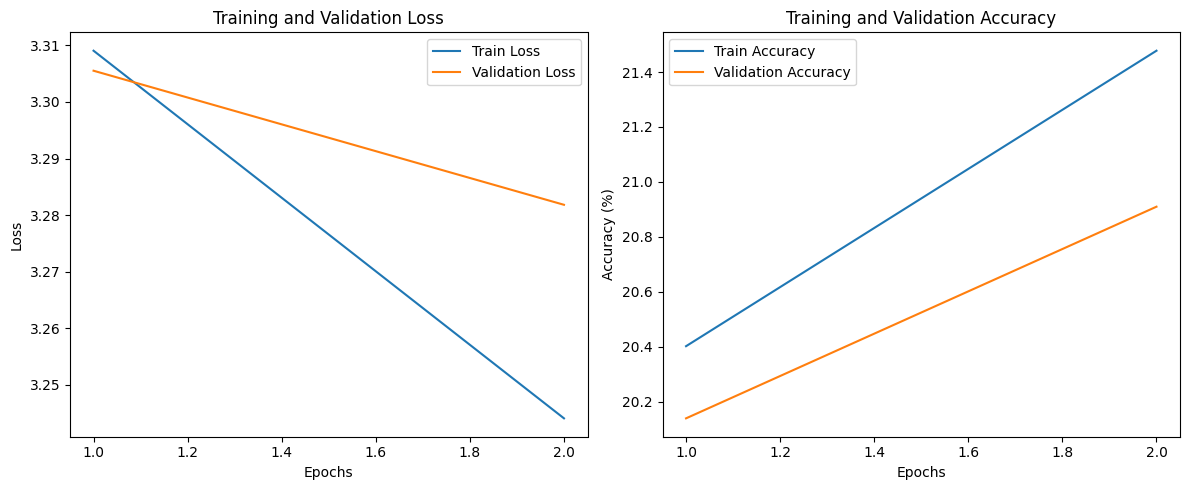

In [ ]:
if __name__ == "__main__":

    # Argument parser to allow optimizer selection from command line
    parser = argparse.ArgumentParser(description="Large Batch Training with Optimizers")
    parser.add_argument('--optimizer', type=str, required=True, choices=['SGDM', 'AdamW', 'LARS', 'LAMB'], help="Optimizer to use")
    parser.add_argument('--batch_size', type=int, nargs='+', default=[512],choices=[128, 256, 512, 1024, 2048, 4096, 8192], help="List of batch sizes to test")
    args = parser.parse_args()

    """
    # Necessary to run it in colab
    class Args:
        optimizer = 'SGDM'
        batch_size=  512

    args = Args()"""
    train_dataset, train_loader, val_loader, test_loader = get_dataset(args.batch_size)

    if args.optimizer == 'SGDM' or args.optimizer == 'LARS':
        try:
          with open('/content/drive/MyDrive/best_hyperparams_SGDM.json', 'r') as f:
              hyperparams = json.load(f)
        except FileNotFoundError:
          hyperparams = {
              'lr': 0.01  ,
              'weight_decay': 0.001,
              'momentum': 0.9,
          }

    elif args.optimizer == 'AdamW' or args.optimizer == 'LAMB':
        try:
          with open('/content/drive/MyDrive/best_hyperparams_AdamW.json', 'r') as f:
              hyperparams = json.load(f)
        except FileNotFoundError:
          hyperparams = {
              'lr':  0.001,
              'weight_decay': 0.1,
          }
    else:
        raise ValueError("Invalid optimizer type")


    base_lr = hyperparams['lr']
    # Scale root factor
    lr = base_lr * math.sqrt(args.batch_size/BATCH_SIZE_BASE)
    hyperparams['lr'] = lr

    print(f"Using hyperparams: lr: {hyperparams['lr']}, weight_decay: {hyperparams['weight_decay']}, optimizer: {args.optimizer}")

    # Train with the best hyperparameters
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        hyperparams=hyperparams,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        type_of_optimizer=args.optimizer,
        batch_size=args.batch_size,
        train_dataset=train_dataset
    )

    plot_results(train_losses, val_losses, train_accuracies, val_accuracies)